In [6]:
from templates import *
from templates_cls import *
from experiment_classifier import ClsModel
import matplotlib.pyplot as plt

In [2]:
device = 'cuda:0'
conf = ffhq256_autoenc()
# print(conf.name)
model = LitModel(conf)
state = torch.load(f'checkpoints/{conf.name}/last.ckpt', map_location='cpu')
model.load_state_dict(state['state_dict'], strict=False)
model.ema_model.eval()
model.ema_model.to(device);

Seed set to 0


Model params: 160.69 M


In [3]:
cls_conf = ffhq256_autoenc_cls()
cls_model = ClsModel(cls_conf)
state = torch.load(f'checkpoints/{cls_conf.name}/last.ckpt',
                    map_location='cpu')
print('latent step:', state['global_step'])
cls_model.load_state_dict(state['state_dict'], strict=False);
cls_model.to(device)

Seed set to 0


loading pretrain ... 130M
step: 1563562
loading latent stats ...
latent step: 9375


ClsModel(
  (model): BeatGANsAutoencModel(
    (time_embed): TimeStyleSeperateEmbed(
      (time_embed): Sequential(
        (0): Linear(in_features=128, out_features=512, bias=True)
        (1): SiLU()
        (2): Linear(in_features=512, out_features=512, bias=True)
      )
      (style): Identity()
    )
    (input_blocks): ModuleList(
      (0): TimestepEmbedSequential(
        (0): Conv2d(3, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      )
      (1-2): 2 x TimestepEmbedSequential(
        (0): ResBlock(
          (in_layers): Sequential(
            (0): GroupNorm32(32, 128, eps=1e-05, affine=True)
            (1): SiLU()
            (2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          )
          (h_upd): Identity()
          (x_upd): Identity()
          (emb_layers): Sequential(
            (0): SiLU()
            (1): Linear(in_features=512, out_features=256, bias=True)
          )
          (cond_emb_layers): Sequential(
          

In [4]:
data = ImageDataset('imgs_align', image_size=conf.img_size, exts=['jpg', 'JPG', 'png'], do_augment=False)
batch = data[0]['img'][None]

In [9]:
cond = model.encode(batch.to(device))
xT = model.encode_stochastic(batch.to(device), cond, T=250)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-5.9074984..5.9356847].


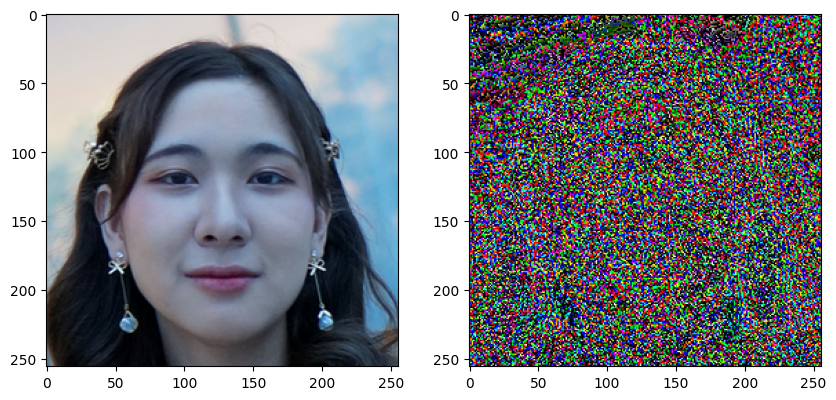

In [10]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ori = (batch + 1) / 2
ax[0].imshow(ori[0].permute(1, 2, 0).cpu())
ax[1].imshow(xT[0].permute(1, 2, 0).cpu())

In [15]:
print(CelebAttrDataset.id_to_cls)
print(len(CelebAttrDataset.id_to_cls))

['5_o_Clock_Shadow', 'Arched_Eyebrows', 'Attractive', 'Bags_Under_Eyes', 'Bald', 'Bangs', 'Big_Lips', 'Big_Nose', 'Black_Hair', 'Blond_Hair', 'Blurry', 'Brown_Hair', 'Bushy_Eyebrows', 'Chubby', 'Double_Chin', 'Eyeglasses', 'Goatee', 'Gray_Hair', 'Heavy_Makeup', 'High_Cheekbones', 'Male', 'Mouth_Slightly_Open', 'Mustache', 'Narrow_Eyes', 'No_Beard', 'Oval_Face', 'Pale_Skin', 'Pointy_Nose', 'Receding_Hairline', 'Rosy_Cheeks', 'Sideburns', 'Smiling', 'Straight_Hair', 'Wavy_Hair', 'Wearing_Earrings', 'Wearing_Hat', 'Wearing_Lipstick', 'Wearing_Necklace', 'Wearing_Necktie', 'Young']
40


In [21]:
cls_id = CelebAttrDataset.cls_to_id['Bald']

In [24]:
cond2 = cls_model.normalize(cond)
cond2 = cond2 + 0.9 * math.sqrt(512) * F.normalize(cls_model.classifier.weight[cls_id][None, :], dim=1)
cond2 = cls_model.denormalize(cond2)

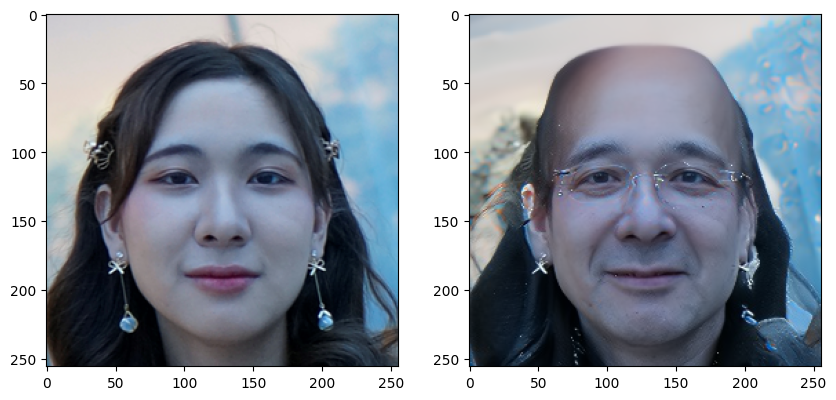

In [25]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
img = model.render(xT, cond2, T=100)
ori = (batch + 1) / 2
ax[0].imshow(ori[0].permute(1, 2, 0).cpu())
ax[1].imshow(img[0].permute(1, 2, 0).cpu())
plt.savefig('imgs_manipulated/compare.png')